# State array analysis for single-particle tracks
Alec Heckert, Liza Dahal, Robert Tijan, Xavier Darzacq (2022) Recovering mixtures of fast-diffusing states from short single-particle trajectories eLife 11:e70169  
https://doi.org/10.7554/eLife.70169

## Imports

In [1]:
# main python packages
from glob import glob
import os
from os.path import join
from pathlib import Path

# 3rd party packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib_scalebar.scalebar as sb
import numpy as np
import pandas as pd
from saspt import StateArray, RBME
from saspt.lik import RBMELikelihood
import scipy.io

# locally installed package
import biteen_utilities as bu

# to suppress annoying warning
plt.rcParams["font.sans-serif"] = ["DejaVu Sans"]

## Where is data coming from? Where is output going?

In [2]:
## where is data coming from?
fits_folder = r"T:\MIGRATED\Python\biteen_notebooks_example_data\LAM_RNAP_SMALLLABS" # drive letter may be different on your computer
fits_pattern = "*_fits.mat"

masks_folder = r"T:\MIGRATED\Python\biteen_notebooks_example_data\LAM_RNAP_SMALLLABS"
masks_pattern = "*_PhaseMask.mat"

## where will output be saved
output_folder = join(os.getcwd(), "state_array_output") # cwd: current working directory
probabilities_csv_fname = "state_array_test_output.csv"
figures_pdf_fname = "state_array_test_plots.pdf"

## Parameters

In [3]:
## parameters
# track filtering parameters
min_track_len = 6 # in number of localizations
max_track_len = np.inf

# state array parameters
pixel_size_um = 0.049 # um
frame_interval = 0.04 # seconds
focal_depth = 0.7 # um
diff_coefs = np.logspace(-3, 1, 100) # um^2 / s
loc_errors = np.linspace(0, 0.1, 30) # um
likelihood_type = RBME # imported from saspt package

## plotting parameters
cmap = mpl.cm.cool 
vmin = np.log10(diff_coefs[0])
vmax = np.log10(diff_coefs[-1])
lmin = -2 # tracks with D_app < 10^lmin will appear cyan
lmax = -1 # tracks with D_app > 10^lmax will appear magenta

# overall plot
ymax_overall_plot = None
minor_line_color = 'xkcd:grey'
minor_line_width = 1.5
minor_line_alpha = 0.3
major_line_color = 'xkcd:black'
major_line_width = 3

# movie plots
ymax_movie_plot = None
roi_line_width = 1 
roi_line_alpha = 0.5
roi_line_color = 'xkcd:gray'
marker_size = 5
marker_alpha = 0.33


# scalebar parameters
default_scalebar_props = {
    'dx': pixel_size_um,
    'units': 'um',
    'fixed_value': 2,
    'scale_loc': 'none',
    'location': 'lower right',
    'frameon': False,
    'color': 'xkcd:white'
}

## Analysis

### Reading and preparing data

In [4]:
# find all the fits files
fits_files = glob(join(fits_folder, fits_pattern)) 

# find mask files
masks_files = glob(join(masks_folder, masks_pattern)) 

# check for matching number of files
print(f"{len(fits_files)} fits files found and {len(masks_files)} masks files found")
if len(fits_files) != len(masks_files):
    print("Warning: there should be one masks file for every fits file")

# initiate a list to hold DataFrames containing fits data
all_dfs = [] 
curr_max_id = 0

# loop over fits files:
for i, fits_file in enumerate(fits_files):

    # read SMALL-LABS fit file and convert to pandas DataFrame
    fits_data = bu.slfile_to_df(fits_file)
    
    # only consider good fits
    fits_data = fits_data[fits_data['goodfit'] == True] 

    # filter tracks by number of localizations
    fits_data = bu.filter_by_nlocs(
        fits_data, 
        min_locs=min_track_len, 
        max_locs=max_track_len, 
        track_col='track_id'
        )
    
    # provide unique movie id
    fits_data['movie_id'] = i

    # shift track_ids to be unique
    track_ids = fits_data['track_id'].dropna().unique()
    n_ids = len(track_ids)
    new_ids = np.arange(n_ids) + curr_max_id
    curr_max_id = new_ids[-1] + 1
    fits_data['track_id_unique'] = fits_data['track_id'].replace(
        track_ids,
        new_ids
    )

    # build list of DataFrames
    all_dfs.append(fits_data)

# assemble into single DataFrame for passing into state array analysis
all_fits = pd.concat(all_dfs, ignore_index=True)

# create unique roinum across movies
all_fits['roinum_unique'] = all_fits.groupby(['movie_id', 'roinum']).ngroup() + 1

# rename columns for state array analysis
detections = all_fits.rename(columns={
    'col': 'x',
    'row': 'y',
    'track_id_unique': 'trajectory'
    })

# load masks
all_masks = [scipy.io.loadmat(masks_file)['PhaseMask'] for masks_file in masks_files]

21 fits files found and 21 masks files found


### State array calculation

In [5]:
# define model
rbme_likelihood = RBMELikelihood(
    pixel_size_um = pixel_size_um, # um
    frame_interval = frame_interval, # seconds
    focal_depth = focal_depth, # um
    diff_coefs = diff_coefs, # um^2/s
    loc_errors = loc_errors # um
    )
settings = dict(
    likelihood_type = likelihood_type,
    pixel_size_um = pixel_size_um, # um
    frame_interval = frame_interval, # seconds
    focal_depth = focal_depth, # um
    progress_bar = True,
)

# run state array analysis with model
SA = StateArray.from_detections(
    detections[['x', 'y', 'trajectory', 'frame']], 
    **settings
    )
SA.likelihood = rbme_likelihood
SA.posterior_assignment_probabilities;

c:\Users\djfoust\Anaconda3\envs\saspt-dan\lib\site-packages\saspt\trajectory_group.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections[cls.DETECT_INDEX] = np.arange(len(detections), dtype=np.int64)


inferring posterior distribution...


100%|██████████| 200/200 [00:20<00:00,  9.65it/s]


### Secondary calculation, e.g. D_av for each trajectory

In [6]:
# find estimated probabilities for each individual
track_probabilities = SA.posterior_assignment_probabilities.sum(axis=1)

# find expectation value of diffusion coefficient for each track
Dav_track = (track_probabilities * SA.diff_coefs[:,None]).sum(axis=0)
detections_sa = SA.trajectories.detections # distinct from detections because analysis does not necessarily use all localizations
detections_sa['D_av'] = Dav_track[detections_sa['trajectory']]

# find overall probability
overall_probability = SA.posterior_occs.sum(axis=1)

### Merge SA detections with input detections

In [7]:
all_fits['track_id_SA'] = np.nan
all_fits.loc[detections_sa['detect_index'], 'track_id_SA'] = detections_sa['trajectory']
all_fits.loc[detections_sa['detect_index'], 'D_av'] = detections_sa['D_av']

all_fits['log10(D_av)'] = np.log10(all_fits['D_av'])

## Plotting

### Creating a custom colormap

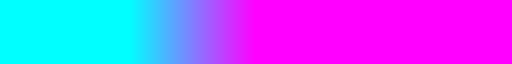

In [8]:
x = np.linspace(0, 1, 256)
n_min = len(x[x<(lmin-vmin) / (vmax - vmin)])
n_max = len(x[x>(lmax-vmin) / (vmax - vmin)])
seg1 = np.array(n_min * [cmap(0.),])
seg2 = cmap(np.linspace(0, 1, 256-n_min-n_max))
seg3 = np.array(n_max * [cmap(1.),])
colors = np.vstack((seg1, seg2, seg3))
coolramp = mpl.colors.ListedColormap(
    colors=np.vstack((seg1, seg2, seg3)), 
    N=256, 
    name='cool_sat'
    )
coolramp

### Plot overall probability

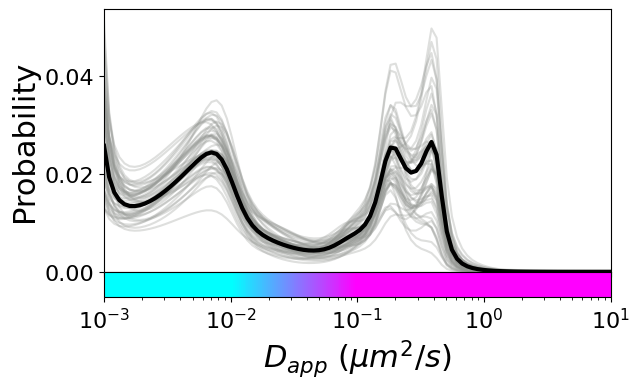

In [9]:
# list for holding figure handles
all_figures = []

# finding tick positions and labels
logD_intervals = np.arange(np.log10(diff_coefs[0]), np.log10(diff_coefs[-1]) + 1)
D_intervals = 10**logD_intervals
xtick_labels = [f"$\\mathdefault{{10^{{{Dint}}}}}$" for Dint in logD_intervals.astype('int')]

# initiate plot
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))

cpo_max = 0
norm = mpl.colors.LogNorm(vmin=diff_coefs[0], vmax=diff_coefs[-1])
scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=coolramp)

for icell in all_fits['roinum_unique'].unique():
    
    cell_fits = all_fits[all_fits['roinum_unique'] == icell]
    cell_fits = cell_fits[~np.isnan(cell_fits['track_id_SA'])]
    cell_track_posteriors = track_probabilities[:, cell_fits['track_id_SA'].unique().astype('int')]

    cell_posterior_occs = (
        cell_track_posteriors * cell_fits.groupby('track_id_SA')['track_id_SA'].count().values
        ).sum(axis=1) / len(cell_fits)
    
    if cell_posterior_occs.max() > cpo_max: cpo_max = cell_posterior_occs.max()

    ax.set_xscale('log')
    ax.set_xlim(left=diff_coefs[0], right=diff_coefs[-1])
    
    ax.plot(diff_coefs, 
            cell_posterior_occs,
            color=minor_line_color,
            lw=minor_line_width,
            alpha=minor_line_alpha)

ax.set_ylabel('Probability', fontsize=22)

if ymax_overall_plot is None: ymax = 1.05 * cpo_max
ax.set_ylim(bottom=0, top=ymax_overall_plot)

ax.plot(diff_coefs, overall_probability, 
        color=major_line_color, lw=major_line_width)

ax.tick_params(axis='x', labelbottom=False)
ax.tick_params(axis='y', labelsize=16)

cbar = plt.colorbar(
    scalar_mappable,
    orientation='horizontal',
    ticks=D_intervals,
    ax=ax,
    label=r'$D_{app}\ (\mu m^2/s)$',
    pad=0
    )

cbar.solids.set(alpha=1)
cbar.ax.set_xticklabels(xtick_labels)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$D_{app}\ (\mu m^2/s)$', fontsize=22)

plt.tight_layout()

all_figures.append(fig)

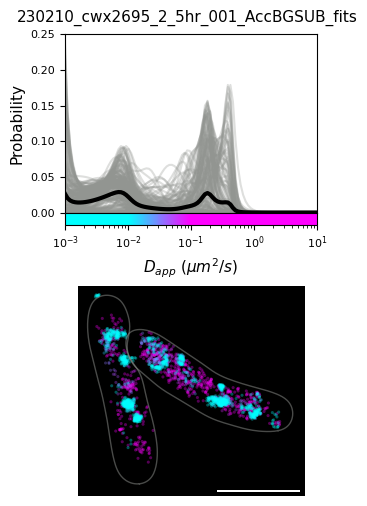

In [ ]:
plt.close('all')

for imov in all_fits['movie_id'].unique():

    # find overall probability for current movie
    movie_fits = all_fits[all_fits['movie_id'] == imov]
    movie_fits = movie_fits[~np.isnan(movie_fits['track_id_SA'])]
    movie_track_probabilities = track_probabilities[:, movie_fits['track_id_SA'].unique().astype('int')]

    movie_probability = (movie_track_probabilities * movie_fits.groupby('track_id_SA')['track_id_SA'].count().values).sum(axis=1) / len(movie_fits)

    mask = all_masks[imov]
    contours = bu.labels_to_contours(mask, level=0.5)
    contours = [[bu.smooth_polygon(contour)] for contour in contours]

    fig, ax = plt.subplots(2,1, figsize=(3.25, 6))
    fig.suptitle(Path(fits_files[imov]).stem, fontsize=11, y=0.92)
    ax[0].set_xscale('log')
    ax[0].set_xlim(left=diff_coefs[0], right=diff_coefs[-1])

    if ymax_movie_plot is None: ymax_movie_plot = movie_track_probabilities.max()*1.05
    ax[0].set_ylim(bottom=0, top=ymax_movie_plot)

    ax[0].plot(diff_coefs, movie_track_probabilities,
               color=minor_line_color,
               lw=minor_line_width,
               alpha=minor_line_alpha)
    ax[0].plot(diff_coefs, movie_probability,
               color=major_line_color,
               lw=major_line_width)
    ax[0].set_ylabel('Probability', fontsize=11)

    ax[0].tick_params(axis='x', labelbottom=False)
    ax[0].tick_params(axis='y', labelsize=8)
    
    ax[1].imshow(np.zeros(mask.shape), cmap='binary_r')
    bu.crop_to_labels(ax[1], mask)
    ax[1].set_axis_off()
    for contour in contours:
        ax[1].plot(contour[0][:,1], contour[0][:,0], 
                   lw=roi_line_width, 
                   alpha=roi_line_alpha, 
                   color=roi_line_color)
    scatmap = ax[1].scatter(
        data=movie_fits.sort_values('D_av', ascending=False),
        x='col',
        y='row',
        c='D_av',
        edgecolor='none',
        alpha=marker_alpha,
        s=marker_size,
        cmap=coolramp,
        norm=norm
        )
    ax[0].set_xticks([])
    cbar = plt.colorbar(
        scatmap,
        orientation='horizontal',
        ticks=D_intervals,
        ax=ax[0],
        label=r'$D_{app}\ (\mu m^2/s)$',
        pad=0
        )
    
    cbar.solids.set(alpha=1)
    cbar.ax.set_xticklabels(xtick_labels)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label(r'$D_{app}\ (\mu m^2/s)$', fontsize=11)
    
    scalebar = sb.ScaleBar(**default_scalebar_props)
    ax[1].add_artist(scalebar)
        
    all_figures.append(fig)

## Saving data

In [11]:
# create output folder if it doesn't already exist
os.makedirs(output_folder, exist_ok=True)

# create DataFrame for storing 
output_df = pd.DataFrame(
    data = {
        'diff_coefs': diff_coefs,
        'overall': overall_probability,
    }
)

# re-calculating for each cell/roi
for icell in all_fits['roinum_unique'].unique():
    cell_fits = all_fits[all_fits['roinum_unique'] == icell]
    cell_fits = cell_fits[~np.isnan(cell_fits['track_id_SA'])]
    cell_track_posteriors = track_probabilities[:, cell_fits['track_id_SA'].unique().astype('int')]
    cell_posterior_occs = (cell_track_posteriors * cell_fits.groupby('track_id_SA')['track_id_SA'].count().values).sum(axis=1) / len(cell_fits)
    output_df[f'roi{int(icell):03}'] = cell_posterior_occs

output_df.to_csv(
    join(output_folder, probabilities_csv_fname)
)

# saving figures to single pdf
image_pdf = PdfPages(join(output_folder, figures_pdf_fname))
for fig in all_figures:
    image_pdf.savefig(fig, bbox_inches='tight')
image_pdf.close()